In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings 
warnings.filterwarnings('ignore')

!pip install --upgrade scikit-learn
!pip install --upgrade scikit-learn imbalanced-learn


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vertebralcolumndataset/Dataset_spine.csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 96.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MaxAbsScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# **EDA**

## **Data Exploration**
    During this step, one can explore the shape of the data being worked with. It is common to check and handle the number of columns and rows, missing values, outliers, and other inconsistencies that might appear.
--

In [3]:
df = pd.read_csv("/kaggle/input/vertebralcolumndataset/Dataset_spine.csv")
df.head()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [4]:
df.dtypes # Checking the data type of each column

pelvic incidence               float64
 pelvic tilt                   float64
 lumbar lordosis angle         float64
 sacral slope                  float64
 pelvic radius                 float64
 grade of spondylolisthesis    float64
Class_att                       object
dtype: object

In [5]:
df_columns = df.columns
df_columns = [x.lstrip().replace(" ","_") for x in df_columns] # stripping the column titles to improved usefulness
df.columns = df_columns

In [6]:
df.isna().mean() # Evaluating the % of missing values in every column

pelvic_incidence              0.0
pelvic_tilt                   0.0
lumbar_lordosis_angle         0.0
sacral_slope                  0.0
pelvic_radius                 0.0
grade_of_spondylolisthesis    0.0
Class_att                     0.0
dtype: float64

In [7]:
# Turning the Class_att column into Boolean

df['abnormality'] = df['Class_att'].map({
    'Abnormal': 1,
    'Normal': 0
})

## **Statistical Analysis**
    This step aims to understand the interaction and correlation among the features. Here, it is possible to check for multicollinearity, plot visualizations, and highlight key points.
--

In [8]:
df.describe().round(2) # Getting the statistics of the dataset

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,abnormality
count,310.00,310.00,310.00,310.00,310.00,310.00,310.00
mean,60.50,17.54,51.93,42.95,117.92,26.30,0.68
std,17.24,10.01,18.55,13.42,13.32,37.56,0.47
min,26.15,-6.55,14.00,13.37,70.08,-11.06,0.00
25%,46.43,10.67,37.00,33.35,110.71,1.60,0.00
50%,58.69,16.36,49.56,42.40,118.27,11.77,1.00
75%,72.88,22.12,63.00,52.70,125.47,41.29,1.00
max,129.83,49.43,125.74,121.43,163.07,418.54,1.00


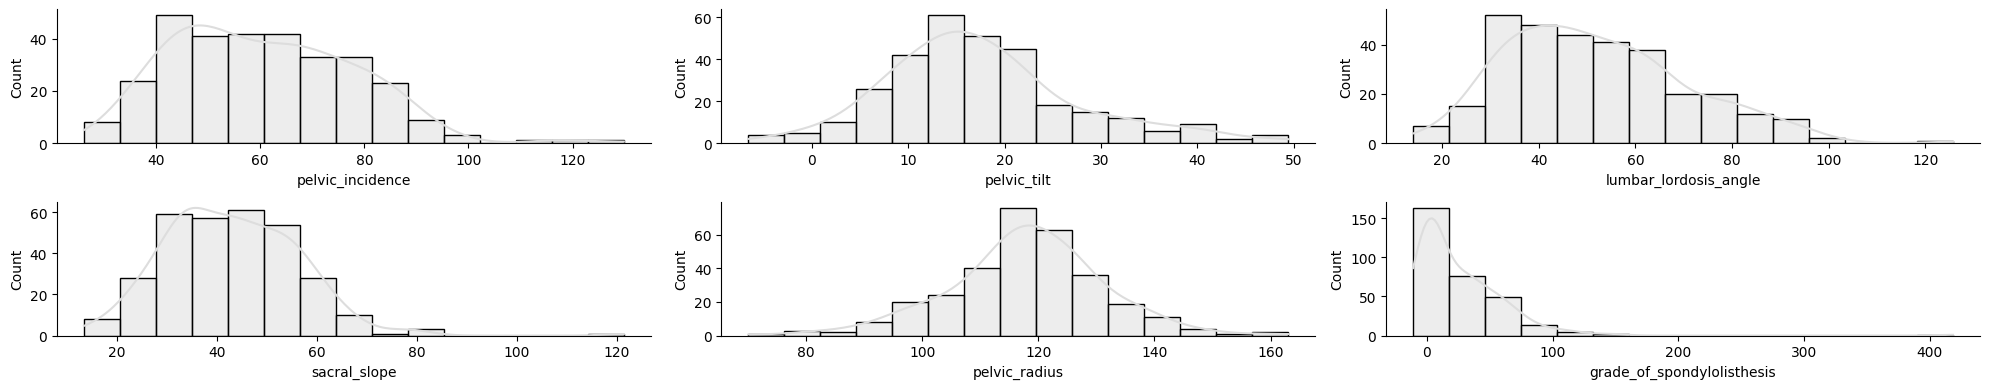

In [9]:
#Plotting the distribution of each feature

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 4))

ax[0,0] = sns.histplot(data=df, x= 'pelvic_incidence', color='#DDDDDD', kde=True, ax=ax[0,0], bins=15)
ax[0,1] = sns.histplot(data=df, x= 'pelvic_tilt', color='#DDDDDD', kde=True, ax=ax[0,1], bins=15)
ax[0,2] = sns.histplot(data=df, x= 'lumbar_lordosis_angle', color='#DDDDDD', kde=True, ax=ax[0,2], bins=15)
ax[1,0] = sns.histplot(data=df, x= 'sacral_slope', color='#DDDDDD', kde=True, ax=ax[1,0], bins=15)
ax[1,1] = sns.histplot(data=df, x= 'pelvic_radius', color='#DDDDDD', kde=True, ax=ax[1,1], bins=15)
ax[1,2] = sns.histplot(data=df, x= 'grade_of_spondylolisthesis', color='#DDDDDD', kde=True, ax=ax[1,2], bins=15)


sns.despine(left=False, right=True, top=True, bottom=False)
plt.tight_layout()

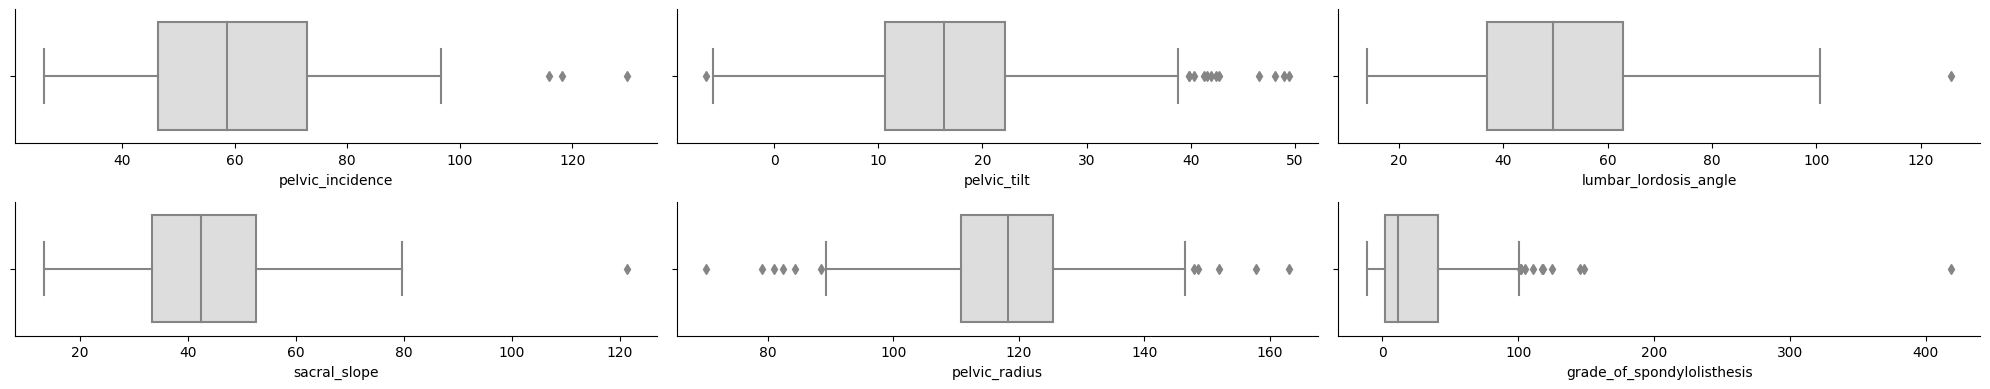

In [10]:
# Plotting BoxPlots to assess Outliers

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 4))

ax[0,0] = sns.boxplot(data=df, x= 'pelvic_incidence', color='#DDDDDD', ax=ax[0,0])
ax[0,1] = sns.boxplot(data=df, x= 'pelvic_tilt', color='#DDDDDD', ax=ax[0,1])
ax[0,2] = sns.boxplot(data=df, x= 'lumbar_lordosis_angle', color='#DDDDDD', ax=ax[0,2])
ax[1,0] = sns.boxplot(data=df, x= 'sacral_slope', color='#DDDDDD', ax=ax[1,0])
ax[1,1] = sns.boxplot(data=df, x= 'pelvic_radius', color='#DDDDDD', ax=ax[1,1])
ax[1,2] = sns.boxplot(data=df, x= 'grade_of_spondylolisthesis', color='#DDDDDD', ax=ax[1,2])

sns.despine(left=False, right=True, top=True, bottom=False)
plt.tight_layout()

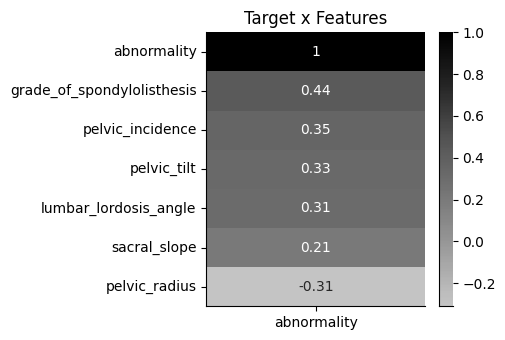

In [11]:
# Watching correlation of each feature against the target.

corr = df.drop('Class_att',axis=1).corr()
target_corr = corr[['abnormality']].sort_values(by='abnormality', ascending=False)

plt.figure(figsize=(5, len(target_corr) * 0.5))
sns.heatmap(target_corr, annot=True, cmap='Greys', center=0)

sns.despine(left=False, right=True, top=True, bottom=False)
plt.title("Target x Features")
plt.tight_layout()

## **Insights:**
--

### **Statistics**:
* As we can see all features but Pelvic Radius have a positve correlation with the Abnormality target, which means that the more they increease, the higher the chance of findind anormality.

# **Machine Learning**

## **Data Preparation**
    To prepare the data to build and test predctive models. 
--

In [12]:
# Checking for Multicolinearity
# We can see that Sacral_slope has a strong correlation with lumbar_lordosis_angle. This is why we will remove it from the dataset to avoid bias and overfitting.

df_filter = corr[((corr >= 0.65) | (corr <= -0.65)) & (corr != 1.000)]
df_filter = df_filter.drop('abnormality', axis=1)
df_filter = df_filter.drop('abnormality', axis=0)
df_filter

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis
pelvic_incidence,NaN,NaN,0.717282,0.81496,NaN,NaN
pelvic_tilt,NaN,NaN,NaN,NaN,NaN,NaN
lumbar_lordosis_angle,0.717282,NaN,NaN,NaN,NaN,NaN
sacral_slope,0.814960,NaN,NaN,NaN,NaN,NaN
pelvic_radius,NaN,NaN,NaN,NaN,NaN,NaN
grade_of_spondylolisthesis,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
dataset = df.drop(['Class_att','sacral_slope'], axis=1)
dataset

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,pelvic_radius,grade_of_spondylolisthesis,abnormality
0,63.027817,22.552586,39.609117,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,108.168725,7.918501,1
...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,117.449062,-4.245395,0
306,53.936748,20.721496,29.220534,114.365845,-0.421010,0
307,61.446597,22.694968,46.170347,125.670725,-2.707880,0
308,45.252792,8.693157,41.583126,118.545842,0.214750,0


In [14]:
# Train, Test split

X = dataset.drop('abnormality', axis=1)
y = dataset['abnormality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)

In [15]:
# Checking balance of the target feature.
# According to the plot, we need to adjust the balance for better accuracy

dataset['abnormality'].value_counts(normalize=True)

abnormality
1    0.677419
0    0.322581
Name: proportion, dtype: float64

In [16]:
# Apply SMOTE to generate synthetic examples for the minority class

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # This is applied ONLY to trainning data.

# Scaling data to improve accuracy

scaler = MaxAbsScaler()

# Fit and transform the data
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.fit_transform(X_test)

## **Testing Models**
    To test and validade base models, run metrics and the confidence interval to evaluate the model's performance
--

In [17]:
# Function to run metrics

def classification_metrics(x):
    accuracy = accuracy_score(y_test, y_predict) * 100
    class_atrix = classification_report(y_test,y_predict)
    
    print(class_atrix)
    print("Accuracy: %.2f%%" % accuracy)

# Function to run confidence interval of the models

def validation_results(results):
  mean = results['test_score'].mean()
  std = results['test_score'].std()
  print("Average Accuracy: %.2f%%" % (mean * 100))
  print("Accuracy interval: [%.2f, %.2f]" % ((mean - 2 * std)*100, (mean + 2 * std) * 100))

def base_models(x, y, test):
    # Call models
    models = {
    "Dummy": DummyClassifier(strategy='stratified', random_state=42),
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}
    results = {}
    
    # Run models
    for name, model in models.items():
        model.fit(x, y) # Train the model
        y_pred = model.predict(test) # Make predictions on the validation set
        accuracy = accuracy_score(y_test, y_pred) # Evaluate accuracy
        results[name] = round(accuracy*100,2) # Store results
            
    print(results)

In [18]:
# With the best performance among the models tested, KNN will be the model I'll focus on.

base_models(X_train_scaled, y_train_resampled, X_test_scaled)

{'Dummy': 50.54, 'Logistic Regression': 76.34, 'K-Nearest Neighbors': 79.57}


#### **Cross-Validation and Model Tunning**
        All base models performed better than the dummy data created for validation. Below we can run Cross-Validation tests to evaluate further

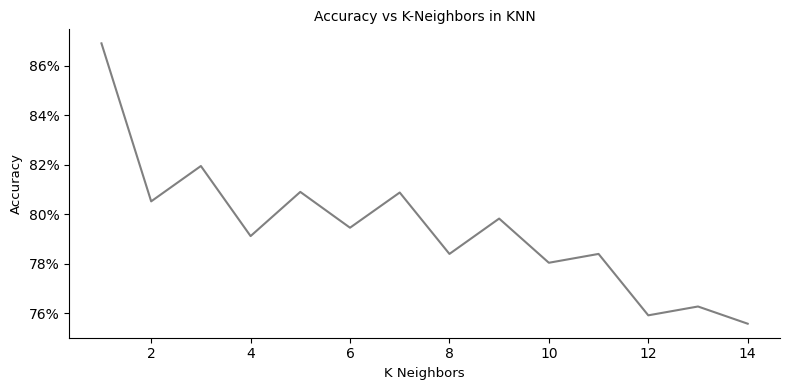

In [19]:
# Applying cross validation to find the optmal params for the model

# Try different values of K
k_values = range(1, 15)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Plotting visualization of the Scores
plt.plot(k_values, accuracy_scores, color='grey')
plt.xlabel('K Neighbors', fontsize=9.5)
plt.ylabel('Accuracy', fontsize=9.5)
plt.title('Accuracy vs K-Neighbors in KNN', fontsize=10)

# Adjusting visualization
formatter = FuncFormatter(lambda x, _: 	f'{x:.0%}')
ax.yaxis.set_major_formatter(formatter)

sns.despine(left=False, right=True, top=True, bottom=False)
plt.tight_layout()

In [20]:
# Fitting KNN after Cross-validation

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train_resampled)
y_predict = knn.predict(X_test_scaled)

classification_metrics(knn)

              precision    recall  f1-score   support

           0       0.64      0.88      0.74        24
           1       0.95      0.83      0.88        69

    accuracy                           0.84        93
   macro avg       0.79      0.85      0.81        93
weighted avg       0.87      0.84      0.85        93

Accuracy: 83.87%


In [21]:
#The Model shows good performance, but it's possible to see that it's giving too many FALSE NEGATIVES

confusion_matrix(y_test, y_predict)

array([[21,  3],
       [12, 57]])

In [22]:
# Trying another model - Decision Tree

tree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
tree.fit(X_train_resampled, y_train_resampled)
y_predict = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.57%


In [23]:
# Trying to improve the Decision Tree with GridSearchCV

tree_for_grid = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],  # None = unlimited depth
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]  # None = all features
}

grid_search = GridSearchCV( estimator=tree_for_grid, param_grid =param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_tree = grid_search.best_estimator_
y_predict = best_tree.predict(X_test)

classification_metrics(best_tree)
print("Best Hyperparameters:", grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.68      0.79      0.73        24
           1       0.92      0.87      0.90        69

    accuracy                           0.85        93
   macro avg       0.80      0.83      0.81        93
weighted avg       0.86      0.85      0.85        93

Accuracy: 84.95%
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [24]:
# It was possible to improve the results, however we still have a high number of FALSE NEGATIVES

confusion_matrix(y_test, y_predict)

array([[19,  5],
       [ 9, 60]])

## **Insights**
--

### **Base Models**:
* All base models present good results when compared to the Dummy classifier. KNN was first choosen due to it's higher accuracy score, however after further validations it was decided to move on with a Decision Tree model optmized with best params.

# **Thank You for taking the time to view this Notebook**!
​
If you found this analysis useful and have any feedback or suggestions, don't hesitate to contact me! We are here to learn!